## Example 1: Fitting data using Linear Least Squares 
#### (not using ready-made software tools, this version is in pure Julia (>=1.1; I am using 1.5.2 now)
Part of ESE 156 Remote Sensing Class; 2020; 
Christian Frankenberg
__________
The purpose of this exercise is to use a very simple linear fit to a set of datapoints as an example for a linear forward model as well as the inversion of the parameters needed to explain the curve-fit. Once you have done this and understood the math behind it, you will be able to apply the strategy to a wider set of problems!

If you have problems because some packages are not yet installed, either go into `package` mode (type `]`, you go back to main Julia prompt by hitting `delete`; hitting `;` gets you a regular console, which is nice!)
```julia
pkg> add Plots, Statistics, Distributions, StatsPlots, LinearAlgebra
```
or
```julia
using Pkg
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("LinearAlgebra")
```


In [2]:
# These commands make other modules available, just like `import` in python
using Plots
using Statistics
using Distributions
using StatsPlots
using LinearAlgebra

### Linefit
Most of you (I hope so) have probably performed fits of a simple linear equation to a $(\vec{x},\vec{y})$ dataset. In the simplest case, we are interested in a linear fit with slope $a_2$ and offset $a_1$, in which case we can write a simple linear equation as $$y = a_1 + a_2\cdot x\,.$$

If we have a set of $n$ points $(x_i,y_i)$, we can find the optimal coefficients $a_1,a_2$ by minimizing the squared differences between measurement and model, hence least squares. Thus, we have to find the coefficients in $a$ that minimize the cost function:

$$\chi^2 = \sum_{i=0}^n \left(y_i-(a_1+a_2 \cdot x_i)\right)^2$$

To find the solution, we can rephrase the problem using linear algebra:


\begin{equation}
\begin{bmatrix}
 y_1 \\ y_2 \\ \vdots \\ y_{n} 
 \end{bmatrix}
 =
 \begin{bmatrix}
  1 && x_1 \\
  1 && x_2 \\
  \vdots && \vdots \\
  1 && x_n
  \end{bmatrix}
  \times
  \begin{bmatrix}
  a_1 \\ a_2 
  \end{bmatrix}
\end{equation}

In short hand, we can use $Ka=y$. The optimal solution to $a$ is obtained by minimizing the squared differences between $Ka$ and $y$, i.e. $min||y-Ka||^2$ or minimize $(y-Ka)^T (y-Ka)$, two different ways of writing it. 

In the ordinary unweighted least squares case, the solution is given by the normal equations (if you want the derivation beyond what we did in class, check e.g. https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression ):
$$a = (K^TK)^{-1}K^Ty$$

*Note:* There are more stable ways to solve the normal equations than the brute force application of the matrix equations but we ignore this for now.


__________
### Simple example
Here, we can use a random number generator to obtain a set of x and y points and then solve the normal equations.

First off, let's explore how to access the documentation. You can just type ? in front of the command. Here, let's test what `randn` is all about:

In [3]:
?randn

search: randn lowrankdowndate lowrankdowndate! RankDeficientException



```
randn([rng=GLOBAL_RNG], [T=Float64], [dims...])
```

Generate a normally-distributed random number of type `T` with mean 0 and standard deviation 1. Optionally generate an array of normally-distributed random numbers. The `Base` module currently provides an implementation for the types [`Float16`](@ref), [`Float32`](@ref), and [`Float64`](@ref) (the default), and their [`Complex`](@ref) counterparts. When the type argument is complex, the values are drawn from the circularly symmetric complex normal distribution of variance 1 (corresponding to real and imaginary part having independent normal distribution with mean zero and variance `1/2`).

# Examples

```jldoctest
julia> using Random

julia> rng = MersenneTwister(1234);

julia> randn(rng, ComplexF64)
0.6133070881429037 - 0.6376291670853887im

julia> randn(rng, ComplexF32, (2, 3))
2×3 Array{Complex{Float32},2}:
 -0.349649-0.638457im  0.376756-0.192146im  -0.396334-0.0136413im
  0.611224+1.56403im   0.355204-0.365563im  0.0905552+1.31012im
```


---
Great, we found a random number generator for Gaussian noise, which is our assumption (most often valid due to the central limit theorem). So we can continue:

In [4]:
# True values for offset and slope:
a1 = 0.0
a2 = 3.0

# define noise level
noise = 1.5

# Generate a random set of x and y (note, we fix x here, i.e. x is without "error"):
# `collect` just turns 1:0.1:5 into a real array.
x = collect(1.0:0.1:5.0)
n = length(x)

41

Offset 0.2304770374018228
Slope 3.033362067249684


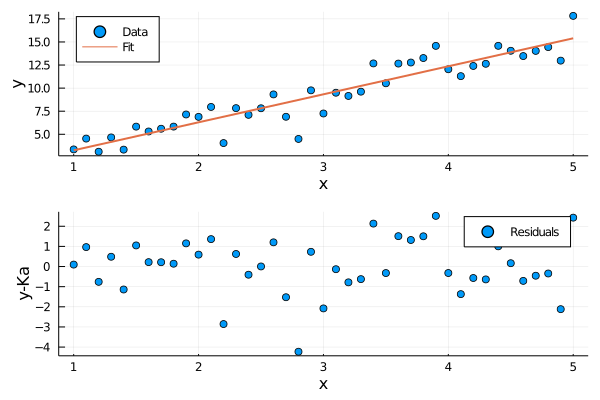

In [8]:
# Create normal distributed noise (using randn, we need to scale with our noise level)
ϵ = noise.*randn(n)

# Compute y given x and add some random number (normal distribution) to it
# anim = @animate  for i ∈ 1:20
# ϵ = noise.*randn(n)

# Construct noisy pseudo-measurements
y = a1.+ a2.*x .+ ϵ
# Define K matrix here (why is that so?)
K = [ones(n) x]

# Plot all dots
p1 = plot(x, y, seriestype=:scatter,ylabel="y", xlabel="x", label="Data", legend=:topleft )

# Solve Normal Equation (see how easy this is in Julia?):
a = inv(K'K)K'y

println("Offset ", a[1])
println("Slope ", a[2])

# Reconstruct fit (if you write plot! it writes OVER what you had before, not creating something new):
plot!(x, K*a, lw=2, label="Fit")

# Plot residuals
p2 = plot(x, y-K*a, seriestype=:scatter, ylabel="y-Ka", xlabel="x", label="Residuals")
 
#end;
# Plot command here has to be at the end to show up:
plot(p1, p2,  layout = (2,1))

In [ ]:
#gif(anim,  fps = 5)

1.3812339427117124
1.3806556449715153


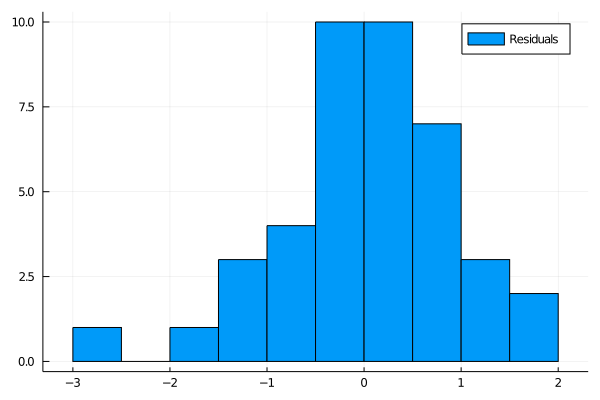

In [10]:
# Let's look at noise normalized residuals:

println(std(ϵ))
println(std(y - K*a))
histogram((y - K*a)./noise,bins=10,label="Residuals")

### Goodness of fit
A bad correlation coefficient between $x$ and $y$ doesn't necessarily mean that there is no causation. A better metric for the goodness of fit is the $\chi^2$ statistics, as our model-data mismatches should follow that statistic if they behave the way we expected. 
Of particular importance is the reduced $\chi^2$, which we can define as
$$\chi_r^2 = \frac{\chi^2}{DOF}$$
with the degrees of freedom DOF defined as the number of observations $n$ minus the number of fitted parameters. The $\chi^2$ distribution represents the distribution of a sum of the squares of k independent standard normal random variables. This is exactly what we have if we take the sum of the squared residuals (actually the quantity that we minimize!).
See https://en.wikipedia.org/wiki/Chi-square_distribution


In [11]:
# Regular χ²:
χ² = sum(((K*a.-y)./noise).^2)
# reduced χ²:
χ²_r = χ²/(n-length(a))
println(χ²_r)
#print(np.corrcoef(x, y)[0,1]**2)

0.8689276398822614


----------------------------

Now let's try to do some same with a better knowledge of the individual measurement errors, which we can include in a measurement error covariance matrix $S_\epsilon$. In the simplest case, $S_\epsilon$ is purely diagonal as measurement errors are usually not correlated with each other (but could). We keep it in Matrix form here to remain general but use a diagonal form.

\begin{equation}
S_{\epsilon} = \left( \begin{array}{ccccc}
\sigma_1^2 & \hfill & \hfill & \hfill & \hfill \\
\hfill & \sigma_2^2 & \hfill & \hfill & \hfill \\
\hfill & \hfill & \ddots &\hfill & \hfill \\
\hfill & \hfill & \hfill & \sigma_{n-1}^2 & \hfill \\
\hfill & \hfill & \hfill & \hfill & \sigma_{n}^2 \\
\end{array} \right)
\end{equation}

with the inverse $S^{-1}_{\epsilon}$ for the diagonal case being:
\begin{equation}
S^{-1}_{\epsilon} = \left( \begin{array}{ccccc}
1/\sigma_1^2 & \hfill & \hfill & \hfill & \hfill \\
\hfill & 1/\sigma_2^2 & \hfill & \hfill & \hfill \\
\hfill & \hfill & \ddots &\hfill & \hfill \\
\hfill & \hfill & \hfill & 1/\sigma_{n-1}^2 & \hfill \\
\hfill & \hfill & \hfill & \hfill & 1/\sigma_{n}^2 \\
\end{array} \right)
\end{equation}

What we need to derive now is the minimum of the weighted differences. In matrix form, the sum of the weighted squared difference can be written as $$(y-Ka)^T S^{-1}_{\epsilon} (y-Ka)$$. Here, $S_{\epsilon}^{-1}$ is now the weighting matrix $W$ that we used in the derivation of the normal equations (and it weighs each squared residual with the inverse of its variance, which is what we want!).

Finding the zero slope in the derivate with respect to a thus yields a slightly modified equation to above, as derived in Lecture Video 3:
$$a = (K^T S^{-1}_\epsilon K)^{-1}K^T S^{-1}_\epsilon y$$

Compare this to the optimal solution found in Rodgers at page 25, equation 2.30. What is the main difference? 
_______________



Let us try solving the same problem as above again, this just using the knowledge that the $1\sigma$ error the same as previously defined as "noise" level, a constant noise for each measurement. 

In [12]:
# Construct error covariance matrix
Sϵ = Diagonal((ones(length(ϵ)).*noise).^2);

And now solve the equation again as before:

Offset 0.2304770374018401
Slope 3.0333620672496755


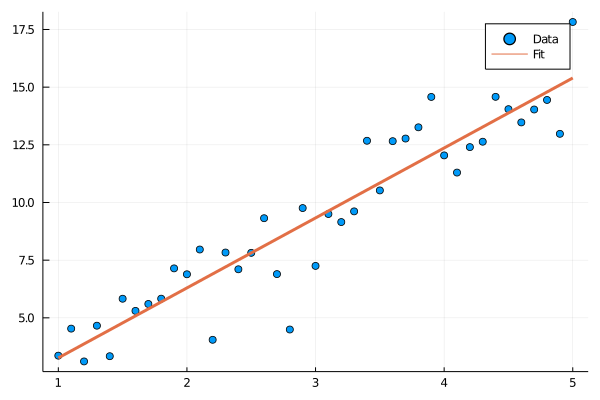

In [14]:
# somewhat overkill here as invSe is diagonal but it works:
aS = inv(K'inv(Sϵ)*K)K'inv(Sϵ)*y

println("Offset ", aS[1])
println("Slope ", aS[2])

# Reconstruct fit:
scatter(x,y, label="Data") 
plot!(x, K*aS, label="Fit",lw=3)

### What use is this?
______
In this example, the 2 solutions are identical as the weighting is the same for each measurement (which can be changed). The biggest advantage in having an idea about the actual measurement uncertainty is that we can derive  uncertainties in the derived state vector $a$ (in the future, we will use $x$ for the state vector).
The error covariance of the retrieved state vector is (which we kind of computed already before), see derivation in Rodgers, eq. 2.27, which includes prior knowledge of our state vector:

$$\hat{S}=(K^T S^{-1}_\epsilon K)^{-1}$$

What does $\hat{S}$ represent? It shows how the retrieved state vector $\hat{x}$ varies around the true value of $x$. This distribution is again normally distributed with the covariance matrix $\hat{S}$.

If the noise matrix is purely diagonal and all elements are identical, we can simplify this to 
$$\hat{S}=\chi^2_r (K^T K)^{-1}$$

This has the advantage that we can pre-compute $(K^T K)^{-1}$ in many cases where this remains constant and can be applied to a multitude of problem sets. 

____


In [ ]:
# Posterior covariance matrix S
Ŝ = inv(K'inv(Sϵ)K)

_______
This might be something you have never really paid attention to as most standard methods never provide the full error covariance matrix (the 2x2 matrix here really is an easy case). 
What does the off-diagonal mean? The errors seems to correlated with the correlation coefficient $corr(a_1,a_2)=cov(a_1,a_2)/(std(a_1)\cdot std(a_2))$

In [ ]:
println("Correlation between retrieved a1 and a2: ", Ŝ[1,2]/(sqrt(Ŝ[1,1]*sqrt(Ŝ[2,2]))))
println("1σ error in a1: ", sqrt(Ŝ[1,1]))
println("1σ error in a2: ", sqrt(Ŝ[2,2]))

_____
<font color=red>**Question:**</font>  Any idea why these variable are correlated with each other (negatively!)? Can you think of a graphical explanation of it?

______________________
<font color=red>**Question:**</font> How could you re-phrase the problem to make the fits of $a_1$ and $a_2$ more independent of each other?

____
Let us run it again using an ensemble to look at the distribution of retrieved properties:


In [ ]:
# Pre-compute Gain Matrix G as we don't need to do that all the time:
@time Gain = inv(K'inv(Sϵ)K)K'*inv(Sϵ)

# True values:
a1 = 0
a2 = 3

# Number of samples:
samples = 10000
ar = zeros((samples,2))
chi2_ = zeros((samples,))
println(a1,a2)

# Loop through different random fits
for i=1:samples
    y = a1.+a2.*x .+ noise.*randn(length(x))
    a = Gain*y
    ar[i,1]=a[1]
    ar[i,2]=a[2]
    # Save reduced chi2 as well:
    chi2_[i]=sum(((K*a-y)./noise).^2)/(n-length(a))
end

In [ ]:
scatter(ar[:,1],ar[:,2],markersize=0.5, alpha=0.15, label="Fitted parameters")

In [ ]:
# There is a tool for that 
cornerplot(ar, compact=true, label = ["a$i" for i=1:2])

In [ ]:
# Let's take a look at the covariance computed from the set of retrieved a_1 and a_2
cov(ar)

In [ ]:
Ŝ

____
Compare the "data-derived" distribution with the one we predicted using the error-covariance before. Due to the large sample size, they come pretty close. In our case, this was a well behaved example with Gaussian errors but this example also gives you an idea how to derive error statistics using monte carlo simulations (which could draw random errors from a non-Gaussian distribution for instance).

In [ ]:
dof = n-length(a)
rv = Chisq(dof)
xx = 0.35:0.02:2.5
plot(xx,pdf.(rv,xx*dof)*dof,lw=3, alpha=0.5,  label="Theoretical")
histogram!(chi2_,t=:density,label="Measured" )
xlabel!("χ²_r")
#plt.legend()
#print(dof)

In [ ]:
plot(xx,cdf.(rv,xx*dof),lw=3, alpha=0.5,  label="Theoretical")

_____
<font color=red>**Question:**</font> 
How would you define suitable thresholds for $\chi^2$ to filter out data that didn't match your expected noise behavior?  

_____
<font color=red>**Question:**</font> 
How can you change the setup mentioned before to use different polynomial degrees? How would you force the fit to go through the origin? How would you use Legendre Polynomials or other functions instead of simple polynomials used here? 